# Community detection for identifying WUJ pages

### Read graph

In [74]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

In [136]:
# get networkx graph
G = nx.read_gpickle("../data/processed/5_hits_per_contentID_graph.gpickle")

# get undirected version of G
GU = G.to_undirected()

# get SaB pages
sab_pages = pd.read_csv("../data/processed/sab_pages.csv").pagePath.tolist()

# get adjacency matrix of G
A = nx.adj_matrix(G, weight=None)

# get adjacency matrix of GU
AU = nx.adj_matrix(G, weight=None)

### Helper functions

In [83]:
def evaluate(true_pages, predicted_pages):
    '''
    true_pages is a list of all the pages known to belong to a WUJ
    predicted_pages ia a list of pages predicted to belong to a WUJ
    
    returns precision and recall as percentages
    '''
    
    true_pages = set(true_pages)
    predicted_pages = set(predicted_pages)
    
    # what proportion of true pages were correctly predicted?
    recall = len(true_pages.intersection(predicted_pages))/len(true_pages)*100
    
    # what proportion of predicted pages are true pages?
    precision = len(true_pages.intersection(predicted_pages))/len(predicted_pages)*100
    
    return (precision, recall)

def getSlugs(G):
    '''
    Returns a list of slugs, given a networkx graph G.
    '''
    return [node[1]['properties']['name'] for node in G.nodes(data=True)]

def showGraph(G, figsize=None):
    '''
    Prints graph information and plots the graph, G.
    Takes figsize as input, a tuple, e.g. (10,10)
    '''
    print(nx.info(G))
    plt.figure(figsize=(figsize))
    nx.draw(G)

### Brief analysis of network structure

#### Size of connected components

Strongly connected components in the entire subgraph:

In [119]:
strong_components = [G.subgraph(c) for c in nx.strongly_connected_components(G)]
sorted([g.number_of_nodes() for g in strong_components], reverse=True)[:10]

[34541, 66, 40, 37, 28, 22, 21, 18, 18, 18]

In [118]:
print(nx.info(G))

Name: 
Type: MultiDiGraph
Number of nodes: 53237
Number of edges: 400337
Average in degree:   7.5199
Average out degree:   7.5199


There is one large mass of 34,541 nodes, leaving 18,696 nodes in smaller connected components. Hence, viewing the graph as directed leaves much of the graph inaccessible if random walks are initialised in the largest connected component.

Weakly connected components in the entire subgraph:

In [120]:
weak_components = [G.subgraph(c) for c in nx.weakly_connected_components(G)]
sorted([g.number_of_nodes() for g in weak_components], reverse=True)[:10]

[51639, 49, 24, 14, 10, 9, 9, 9, 8, 8]

Ignoring edge direction groups together 97% of the nodes into a single component, meaning very few nodes are inaccesible if a random walk is initialised in the largest component.

Let's examine sab pages now.

In [121]:
strong_sab_components = [sab_graph.subgraph(c) for c in nx.strongly_connected_components(sab_graph)]
sorted([g.number_of_nodes() for g in strong_sab_components], reverse=True)[:10]

[198, 10, 6, 3, 3, 3, 3, 2, 2, 2]

In [122]:
weak_sab_components = [sab_graph.subgraph(c) for c in nx.weakly_connected_components(sab_graph)]
sorted([g.number_of_nodes() for g in weak_sab_components], reverse=True)[:10]

[273, 16, 3, 2, 2, 1, 1, 1, 1, 1]

If a random walk were only to visit nodes within the SaB WUJ, some nodes will be accessible whether edge direction is ignored or not. Hence, a random walk either needs to be able to leave the space of SaB pages, in order to traverse to smaller components, or be able to perturb its position and land in another component of SaB pages.

89% of pages are within the largest weakly connected component, hence, a random walk will potentially have more ease in finding SaB pages on an undirected graph than a directed graph.

Name: 
Type: MultiDiGraph
Number of nodes: 306
Number of edges: 3268
Average in degree:  10.6797
Average out degree:  10.6797


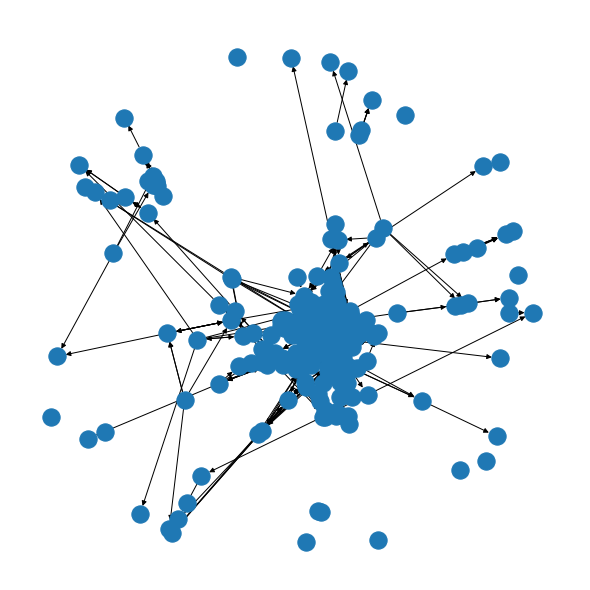

In [133]:
sab_graph = G.subgraph([node[0] for node in G.nodes(data=True) if node[1]['properties']['name'] in sab_pages])
showGraph(sab_graph, figsize=(8,8))

Name: 
Type: MultiGraph
Number of nodes: 306
Number of edges: 3268
Average degree:  21.3595


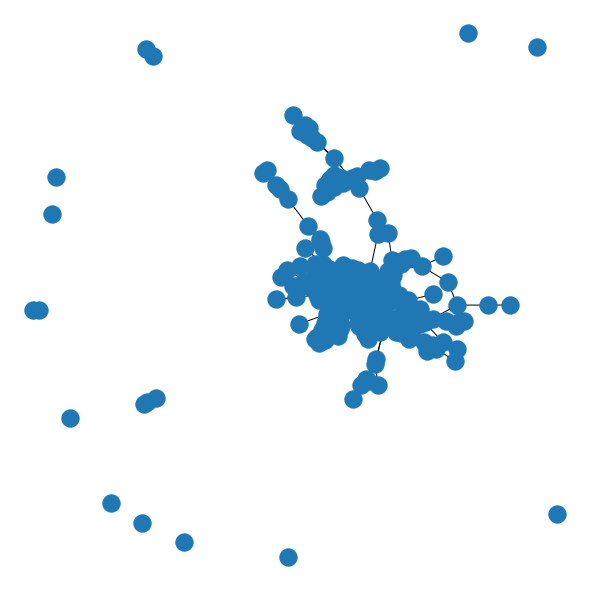

In [134]:
GU = G.to_undirected()
sab_graph_U = GU.subgraph([node[0] for node in GU.nodes(data=True) if node[1]['properties']['name'] in sab_pages])
showGraph(sab_graph_U, figsize=(8,8))

# Random walks

In [262]:
def random_walk(A, G, steps, seed, p=False, nodeData=False):
    '''
    A is an adjacency matrix, or a transition probability matrix. These should be CSR sparse matrices.
    Set p=True if using a transition probability matrix.
    G is a networkx graph.
    steps is the number of steps to take in the random walk.
    seed is a page slug for your starting node in the random walk. E.g. "/set-up-business" 
    
    returns a numpy array of node ids visited during the random walk.
    can return numpy array of nodes with their data if nodeData == True
    '''

    # set a seed node
    foundSeed = False
    for current_node_index, node in enumerate(G.nodes(data=True)):
        if node[1]["properties"]["name"] == seed:
            foundSeed = True
            break
    
    if not foundSeed:
        print("Could not find seed node: {}".format(seed))
        return

    # list of nodes visited during the random walk
    visited = [current_node_index]
    
    transition_probs = None

    for step in range(steps):

        # identify neighbours of current node
        neighbours = np.nonzero(A[current_node_index])[1]

        # if reached an absorbing state, i.e. no neighbours, then terminate the random walk
        if neighbours.size == 0:
            #print("Reached absorbing state after", step, "steps")
            visited = list(set(visited))
            return np.array(G.nodes(data=nodeData))[visited]
        
        # if using transition probabilities, get them
        if p:
            transition_probs = A[current_node_index].toarray()[0, neighbours]
            #transition_probs = A[current_node_index, neighbours].toarray()[0]
        
        # select the index of next node to transition to
        current_node_index = np.random.choice(neighbours, p=transition_probs)

        # maintain record of the path taken by the random walk
        visited.append(current_node_index)
    
    # return unique pages visited
    visited = list(set(visited))
        
    return np.array(G.nodes(data=nodeData))[visited]

In [78]:
def random_walk_T(T, G, steps, seed, nodeData=False):
    '''
    T is transition probability matrix.
    G is a networkx graph.
    steps is the number of steps to take in the random walk.
    seed is a page slug for your starting node in the random walk. E.g. "/set-up-business" 
    
    returns a numpy array of node ids visited during the random walk.
    can return numpy array of nodes with their data if nodeData == True
    '''

    # set a seed node
    foundSeed = False
    for current_node_index, node in enumerate(G.nodes(data=True)):
        if node[1]["properties"]["name"] == seed:
            foundSeed = True
            break
    
    if not foundSeed:
        print("Could not find seed node: {}".format(seed))
        return
    
    # list of nodes visited during the random walk
    visited = [current_node_index]

    for step in range(steps):

        # identify neighbours of current node
        neighbours = np.nonzero(T[current_node_index])[1]

        # if reached an absorbing state, i.e. no neighbours, then terminate the random walk
        if neighbours.size == 0:
            #print("Reached absorbing state after", step, "steps")
            visited = list(set(visited))
            return np.array(G.nodes(data=nodeData))[visited]
        
        # select the index of next node to transition to
        current_node_index = np.random.choice(neighbours,
                                              p=T[current_node_index, neighbours].toarray()[0])
            
            
        # maintain record of the path taken by the random walk
        visited.append(current_node_index)
    
    # return unique pages visited
    visited = list(set(visited))
        
    return np.array(G.nodes(data=nodeData))[visited]

## Naive random walk

Here we're testing the most basic form of random walk, in which a random walk is initialised from a seed page, thereafter successively transitioning to neighbouring nodes, with uniformly distributed transition probabilities. One random walk is initialised per seed node. Each "start a business" page is used as a seed node. The precision and recall of the random walks starting from each of these seed nodes is computed.

  0%|          | 0/306 [00:00<?, ?it/s]

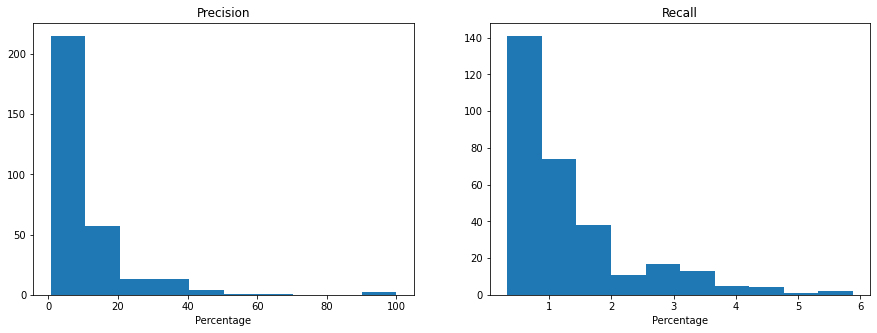

In [140]:
precisions = []
recalls = []

# number of steps to take in random walk
N = 1000

for sab_page in tqdm(sab_pages):
    pred = getSlugs(G.subgraph(random_walk(A, G, N, sab_page)))
    p, r = evaluate(sab_pages, pred)
    precisions.append(p)
    recalls.append(r)
    
fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].hist(precisions);
ax[0].set_title("Precision");
ax[0].set_xlabel("Percentage");
ax[1].hist(recalls);
ax[1].set_title("Recall");
ax[1].set_xlabel("Percentage");

Precision and recall are typically around 10% and 1%, respectively.

### Seed node analysis

Which seed nodes recalled the most SaB pages? Here is the top 10:

In [46]:
sorted(list(zip(recalls, sab_pages)), key=lambda x: -x[0])[:10]

[(7.18954248366013, '/closing-a-limited-company'),
 (6.862745098039216, '/health-and-safety-for-farm-vehicles'),
 (5.228758169934641, '/send-vat-return'),
 (4.901960784313726, '/calculate-your-business-rates'),
 (4.57516339869281, '/special-training-ratings-officers'),
 (4.57516339869281, '/renew-patent'),
 (4.248366013071895, '/creative-works-licence'),
 (4.248366013071895, '/hazardous-waste-producer-registration-wales'),
 (4.248366013071895, '/online-and-distance-selling-for-businesses'),
 (4.248366013071895, '/skip-licence-scotland')]

Since only one random walk is initialised per seed node, these results could happen by chance. Hence, we now initialise multiple random walks per seed node. Then, compute the average precision and recall per seed node, to see if a particular node does best on average.

In [145]:
# these lists will be lists of lists, where each sublist
# contains the precisions and recalls of the repeat random walks
# for a given seed node. e.g.

#                  sab_page_1       sab_page_2              sab_page_n
# precisions = [[0.1,0.15,0.12], [0.2,0.19,0.21], . . ., [0.3, 0.25, 0.12]]

#                                               sab_page_1  sab_page_2    sab_page_n
# then we can compute averages: avg_precisions = [0.123,      0.199, . . ., 0.223]

precisions = []
recalls = []

# number of steps to take in random walk
N = 1000

# number of repeats per seed node
repeats = 100

for sab_page in tqdm(sab_pages):
    
    # to store the precision and recall scores
    # per seed page, for each repeat
    ps = []
    rs = []
    
    for repeat in range(repeats):
        pred = getSlugs(G.subgraph(random_walk(A, G, N, sab_page)))
        p, r = evaluate(sab_pages, pred)
        ps.append(p)
        rs.append(r)
        
    precisions.append(ps)
    recalls.append(rs)

  0%|          | 0/306 [00:00<?, ?it/s]

KeyboardInterrupt: 

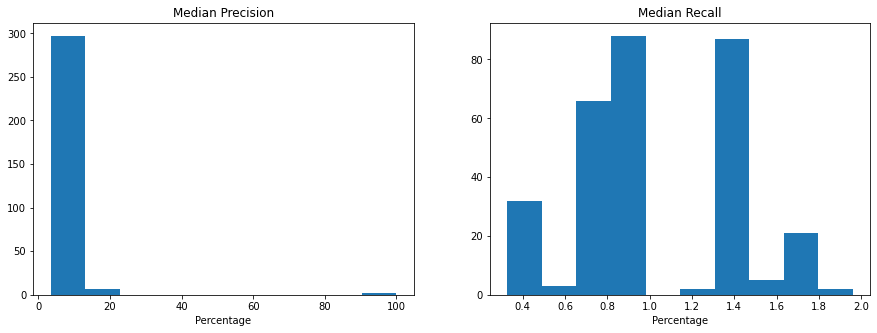

In [76]:
avg_recalls = [np.median(r) for r in recalls]
avg_precisions = [np.median(p) for p in precisions]

fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].hist(avg_precisions);
ax[0].set_title("Median Precision");
ax[0].set_xlabel("Percentage");
ax[1].hist(avg_recalls);
ax[1].set_title("Median Recall");
ax[1].set_xlabel("Percentage");

An average random walk scores 11% on precision and 1% on recall of SaB pages. The following seed pages perform best:

In [80]:
sorted(list(zip(avg_recalls, sab_pages)), key=lambda x: -x[0])[:10]

[(1.9607843137254901, '/food-premises-approval-northern-ireland'),
 (1.7973856209150327, '/food-premises-approval-scotland'),
 (1.6339869281045754, '/doorstep-selling-regulations'),
 (1.6339869281045754, '/road-occupation-licence-for-building-work'),
 (1.6339869281045754, '/cattle-movement-notification-wales'),
 (1.6339869281045754, '/sqa-qualifications-approval-scotland'),
 (1.6339869281045754, '/check-the-design-journal'),
 (1.6339869281045754, '/company-voluntary-arrangements'),
 (1.6339869281045754, '/food-premises-approval'),
 (1.6339869281045754, '/food-safety-hazard-analysis')]

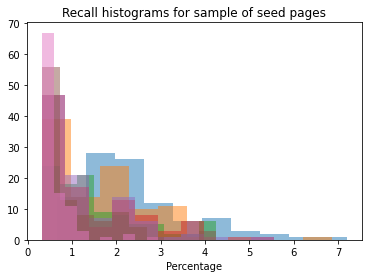

In [42]:
for res in results[::50]:
    plt.hist(res[1], alpha=0.5);
plt.title("Recall histograms for sample of seed pages");
plt.xlabel("Percentage");

## Repeated random walk

Let's use the 3 seed pages with the highest recall from the previous section as seed nodes, then perform M random walks beginning from each of these seed nodes. Hence, we get 3*M sets of pages. The union of these sets is used to define a set of pages related to the SaB WUJ.

In [43]:
top3_sab_pages = sorted(list(zip(recalls, sab_pages)), key=lambda x: -x[0])[:3]
top3_sab_pages = [x[1] for x in top3_sab_pages]
top3_sab_pages

['/closing-a-limited-company',
 '/health-and-safety-for-farm-vehicles',
 '/send-vat-return']

In [146]:
top3_sab_pages = ['/closing-a-limited-company',
                  '/health-and-safety-for-farm-vehicles',
                  '/send-vat-return']

In [150]:
# number of times to initialise random walk from a given seed node
M = 100

# number of steps to take in random walk
N = 1000

pages_visited = list()

for sab_page in tqdm(top3_sab_pages):
    for m in tqdm(range(M)):
        pages_visited.extend(getSlugs(G.subgraph(random_walk(AU, GU, N, sab_page))))
        
pages_visited = list(set(pages_visited))
        
p, r = evaluate(sab_pages, pages_visited)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [151]:
p,r, len(pages_visited)

(2.375580623755806, 58.496732026143796, 7535)

In [152]:
len(set(pages_visited).intersection(set(sab_pages)))

179

With these seed nodes, recall is 60.78%, precision is 2.4%. In other words, 186 out of 306 SaB pages were found, but a set of 7678 pages needed to be collected to find those pages.

### Seed node sensitivity

We need to know how sensitive results are to the choice of seed nodes. Hence, we take all combinations of 3 seed nodes and repeat the above experiment. Since there are $_{306}C_3=4728720$ combinations, we'll do this on a random sample of these combinations.

In [108]:
len(list(combinations(sab_pages,3)))

4728720

In [155]:
from itertools import combinations
from random import sample
sab_samples = sample(list(combinations(sab_pages,3)),20)

In [111]:
precisions = []
recalls = []

# number of times to initialise random walk from a given seed node
M = 100

# number of steps to take in random walk
N = 1000

for sab_sample in tqdm(sab_samples):
    
    pages_visited = list()
    
    for sab_page in sab_sample:
        for m in range(M):
            pages_visited.extend(getSlugs(G.subgraph(random_walk(A, G, N, sab_page))))

    pages_visited = list(set(pages_visited))

    p, r = evaluate(sab_pages, pages_visited)
    
    precisions.append((sab_sample,p))
    recalls.append((sab_sample,r))

  0%|          | 0/20 [00:00<?, ?it/s]

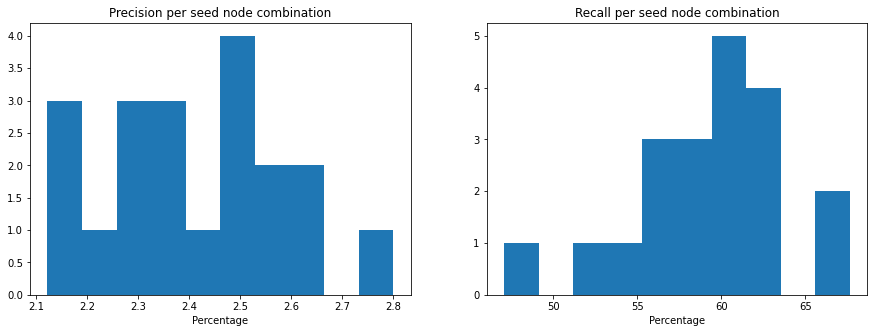

In [130]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].hist([p[1] for p in precisions]);
ax[0].set_title("Precision per seed node combination");
ax[0].set_xlabel("Percentage");
ax[1].hist([r[1] for r in recalls]);
ax[1].set_title('Recall per seed node combination');
ax[1].set_xlabel('Percentage');

Precision is not highly sensitive to the choice of seed nodes, but recall is. Recall ranges from 47% to 67%, but an average recall is 60%. This suggests a strategy for finding "good" combinations of seed nodes exists.

Here are the top 3 seed node combinations, ranked on recall:

In [140]:
sorted(recalls, key=lambda x: -x[1])[:3]

[(('/road-occupation-licence-for-building-work',
   '/apply-for-child-performance-licence',
   '/set-up-limited-company'),
  67.64705882352942),
 (('/unincorporated-associations',
   '/employers-liability-insurance',
   '/scrap-metal-dealer-registration'),
  66.99346405228758),
 (('/protecting-company-from-compulsory-liquidation',
   '/apply-register-design',
   '/late-commercial-payments-interest-debt-recovery'),
  63.39869281045751)]

Here are the bottom 3:

In [138]:
sorted(recalls, key=lambda x: x[1])[:3]

[(('/update-or-surrender-trade-marks',
   '/right-to-contest-answer',
   '/check-trade-marks-journal'),
  47.05882352941176),
 (('/contracts-finder',
   '/file-your-confirmation-statement-with-companies-house',
   '/find-tender'),
  52.94117647058824),
 (('/respond-to-court-claim-for-money',
   '/set-up-sole-trader',
   '/possession-claim-online-recover-property'),
  55.22875816993464)]

### Sensitivity to choice of M and N

The choice of M and N will affect performance. Here we test the performance per choice of M and N with a factorial experiment. We'll evaluate this on the best combination of seed pages found previously: 

  ('/road-occupation-licence-for-building-work',
   '/apply-for-child-performance-licence',
   '/set-up-limited-company')

In [156]:
from itertools import product 

results = {'precision':[], 'recall':[], 'M':[], 'N':[], 'n_pages':[]}

# number of steps to take in random walk
Ns = [50,100,200,300,400,500,600,700,800,900,1000]

# number of times to initialise random walk from a given seed node
Ms = [50,100,200,300,400,500,600,700,800,900,1000]

# all combinations of N and M
NMs = list(product(Ns,Ms))

for N, M in tqdm(NMs):
    
    pages_visited = list()

    for sab_page in ('/road-occupation-licence-for-building-work',
                     '/apply-for-child-performance-licence',
                     '/set-up-limited-company'):
        for m in range(M):

            pages_visited.extend(getSlugs(G.subgraph(random_walk(A, G, N, sab_page))))

    pages_visited = list(set(pages_visited))

    p, r = evaluate(sab_pages, pages_visited)
    
    results['precision'].append(p)
    results['recall'].append(r)
    results['M'].append(M)
    results['N'].append(N)
    results['n_pages'].append(len(pages_visited))

  0%|          | 0/121 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
results_df = pd.DataFrame(results)
results_df.to_csv('rw_mn_experiment.csv')
results_df.head()

In [ ]:
import plotly.express as px

fig = px.scatter_3d(results_df, x='N', y='M', z='recall', color='n_pages')
fig.show()

# Biased random walks

Previously, transition probabilities were uniformly distributed. Hence, the random walk treated all neighbouring nodes as equal. In reality, information from the random walk so far can inform which node to transition to. Now, transition probabilities will be biased using such information, to increase the probability of moving towards nodes that are more relevant to a WUJ.

## Node2vec

In [157]:
n2v = pd.read_csv('../data/processed/n2v_node_embeddings_weighted_8nov21',
                  sep=' ',
                  skiprows=1,
                  header=None)

n2v.rename(columns={0:'cid'}, inplace=True)
n2v['vec'] = n2v.iloc[:,1:].values.tolist()
n2v['vec'] = n2v['vec'].apply(np.array)
n2v.drop(n2v.columns[1:-1], axis=1, inplace=True)

n2v.head()

,cid,vec
0,2977d3b7-e44d-4200-beb3-b3ea4eae9267,"[1.8671892, 2.6098192, -2.3222048, -1.7512394,..."
1,5efc1f67-7631-11e4-a3cb-005056011aef,"[10.41427, 1.7373929, 0.0075460924, 1.0664258,..."
2,774cee22-d896-44c1-a611-e3109cce8eae,"[3.3376453, -2.5657954, -2.1055672, -2.3333597..."
3,632d1ae0-0340-4a23-87b0-595bb596e5f4,"[0.35865974, -1.9952487, -7.7627034, -7.632190..."
4,9ca1a27b-af7b-44d2-b10d-0a6d0e3ff53d,"[3.8525279, -5.164307, -9.626906, -5.730718, -..."


In [158]:
node_ids = pd.DataFrame({
                        'node_id': [n[0] for n in list(G.nodes(data=True))],
                        'cid': [n[1]['properties']['contentID'] for n in list(G.nodes(data=True))]
                        })
node_ids.head()

,node_id,cid
0,488294,c5acf4c3-8a8c-49e1-8d14-5e61fbb1f3c8
1,450289,b1a3bd0c-5da6-4139-b362-9ee40dd50b50
2,47721,19003dea-8169-414a-a18c-7e51366ec08f
3,592592,fc70b57d-a8be-4a95-a7fb-ca15451e8b32
4,466487,ba321772-bc46-49ee-8a6f-85f21ed5957b


In [159]:
n2v = n2v.merge(node_ids, on='cid')
n2v.head()

,cid,vec,node_id
0,2977d3b7-e44d-4200-beb3-b3ea4eae9267,"[1.8671892, 2.6098192, -2.3222048, -1.7512394,...",78413
1,5efc1f67-7631-11e4-a3cb-005056011aef,"[10.41427, 1.7373929, 0.0075460924, 1.0664258,...",252664
2,774cee22-d896-44c1-a611-e3109cce8eae,"[3.3376453, -2.5657954, -2.1055672, -2.3333597...",339181
3,632d1ae0-0340-4a23-87b0-595bb596e5f4,"[0.35865974, -1.9952487, -7.7627034, -7.632190...",301546
4,9ca1a27b-af7b-44d2-b10d-0a6d0e3ff53d,"[3.8525279, -5.164307, -9.626906, -5.730718, -...",411169


In [160]:
G2 = G.subgraph(n2v.node_id).copy()

# remove any possible nodes that refer to themselves
G2.remove_edges_from(nx.selfloop_edges(G2))

In [161]:
# add node2vec vectors as properties in each node
for row in n2v.iterrows():
    # row[1][2] stores the node_id in each n2v row
    # row[1][1] stores the node2vec embedding of this node
    G2.nodes[row[1][2]]['n2v'] = row[1][1]

In [162]:
G2_nodes = np.array(G2.nodes(data=True))

Some SaB pages do not have node2vec embeddings available, hence we'll remove those for now:

In [163]:
G2_pages = [node[1]['properties']['name'] for node in G2_nodes]
sab_pages_2 = [page for page in sab_pages if page in G2_pages]
len(sab_pages_2)

302

#### Compute transition probabilities

In [164]:
from numpy import dot
from numpy.linalg import norm
from scipy.sparse import csr_matrix

# get adjacency matrix
A2 = nx.adj_matrix(G2, weight=None)

# initialise transition matrix
T2 = csr_matrix(A2.shape)

for i in tqdm(range(A2.shape[0])):
    
    # get indexes of neighbouring nodes
    neighbours = np.nonzero(A2[i])[1]
    
    # skip nodes without neighbours
    if neighbours.size == 0:
        continue
    
    # get n2v vectors of neighbouring nodes
    neighbour_n2v = np.array([node[1]['n2v'] for node in G2_nodes[neighbours]])
    
    # get n2v vector of current node
    current_n2v = G2_nodes[i][1]['n2v']
    
    # use n2v vectors to compute cosine similarities between current node and its neighbours
    #cosine_sims = (neighbour_n2v @ current_n2v)/(norm(neighbour_n2v, axis=1) * norm(current_n2v))
    
    # use n2v vectors to compute dot product between current node and its neighbours
    dot_prod = (neighbour_n2v @ current_n2v)
    
    # transition probabilities
    # softmax with base 1.025
    ps = 1.025**(dot_prod)/sum(1.025**(dot_prod))
    
    # insert transition probabilities into transition matrix
    T2[i, neighbours] = ps 

  0%|          | 0/48608 [00:00<?, ?it/s]

C:\Users\JakeR\anaconda3\lib\site-packages\scipy\sparse\_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [29]:
# these lists will be lists of lists, where each sublist
# contains the precisions and recalls of the repeat random walks
# for a given seed node. e.g.

#                  sab_page_1       sab_page_2              sab_page_n
# precisions = [[0.1,0.15,0.12], [0.2,0.19,0.21], . . ., [0.3, 0.25, 0.12]]

#                                               sab_page_1  sab_page_2    sab_page_n
# then we can compute averages: avg_precisions = [0.123,      0.199, . . ., 0.223]

precisions = []
recalls = []

# number of steps to take in random walk
N = 500

# number of repeats per seed node
repeats = 5

for sab_page in tqdm(sab_pages_2):
    
    # to store the precision and recall scores
    # per seed page, for each repeat
    ps = []
    rs = []
    
    for repeat in range(repeats):
        walk_results = random_walk_T(T2, G2, N, sab_page)
        if walk_results is None:
            continue
            
        pred = getSlugs(G2.subgraph(walk_results))
        p, r = evaluate(sab_pages_2, pred)
        ps.append(p)
        rs.append(r)
        
    precisions.append(ps)
    recalls.append(rs)

  0%|          | 0/302 [00:00<?, ?it/s]

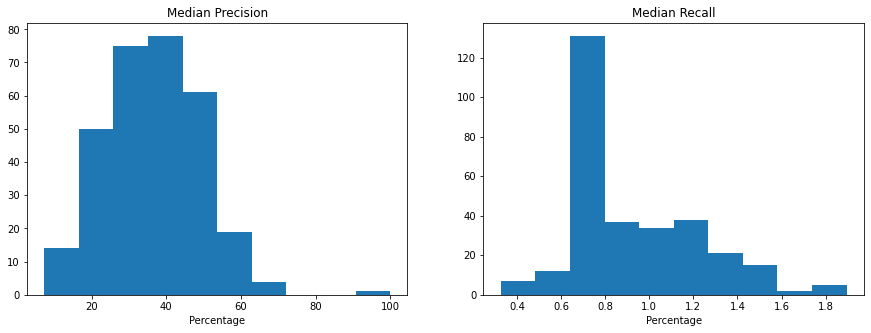

In [32]:
avg_recalls = [np.mean(r) for r in recalls]
avg_precisions = [np.mean(p) for p in precisions]

fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].hist(avg_precisions);
ax[0].set_title("Median Precision");
ax[0].set_xlabel("Percentage");
ax[1].hist(avg_recalls);
ax[1].set_title("Median Recall");
ax[1].set_xlabel("Percentage");

In [41]:
# number of times to initialise random walk from a given seed node
M = 100

# number of steps to take in random walk
N = 500

pages_visited_T = list()
pages_visited = list()

for sab_page in tqdm(np.random.choice(sab_pages_2,3)):
    for m in tqdm(range(M)):
        pages_visited_T.extend(getSlugs(G2.subgraph(random_walk_T(T2, G2, N, sab_page))))
        pages_visited.extend(getSlugs(G2.subgraph(random_walk(T2, G2, N, sab_page))))
        
pages_visited_T = list(set(pages_visited_T))
pages_visited = list(set(pages_visited))
        
p_T, r_T = evaluate(sab_pages_2, pages_visited_T)
p, r = evaluate(sab_pages_2, pages_visited)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [42]:
p_T,r_T,len(pages_visited_T)

(24.81203007518797, 10.927152317880795, 133)

In [43]:
p,r,len(pages_visited)

(2.6239907727797, 60.264900662251655, 6936)

In [179]:
# number of times to initialise random walk from a given seed node
M = 100

# number of steps to take in random walk
N = 50

pages_visited_T = list()
pages_visited = list()

for sab_page in tqdm(np.random.choice(sab_pages_2,3)):
    for m in tqdm(range(M)):
        pages_visited_T.extend(getSlugs(G2.subgraph(random_walk(T2, G2, N, sab_page, p=True))))
        pages_visited.extend(getSlugs(G2.subgraph(random_walk(T2, G2, N, sab_page))))
        
pages_visited_T = list(set(pages_visited_T))
pages_visited = list(set(pages_visited))
        
p_T, r_T = evaluate(sab_pages_2, pages_visited_T)
p, r = evaluate(sab_pages_2, pages_visited)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [180]:
p_T, r_T, len(pages_visited_T)

(13.564668769716087, 14.23841059602649, 317)

In [181]:
p, r, len(pages_visited)

(3.117178612059158, 45.36423841059602, 4395)

### Sensitivity to choice of seed nodes

In [182]:
from itertools import combinations
from random import sample
sab_samples_2 = sample(list(combinations(sab_pages_2,3)),20)

In [186]:
precisions = []
recalls = []

# number of times to initialise random walk from a given seed node
M = 100

# number of steps to take in random walk
N = 100

for sab_sample in tqdm(sab_samples_2):
    
    pages_visited = list()
    
    for sab_page in sab_sample:
        for m in range(M):
            pages_visited.extend(getSlugs(G2.subgraph(random_walk(T2, G2, N, sab_page, p=True))))

    pages_visited = list(set(pages_visited))

    p, r = evaluate(sab_pages_2, pages_visited)
    
    precisions.append((sab_sample,p))
    recalls.append((sab_sample,r))

  0%|          | 0/20 [00:00<?, ?it/s]

In [189]:
sorted(recalls, key=lambda x: -x[1])[:3]

[(('/workplace-fire-safety-your-responsibilities',
   '/renew-patent-trademark-registered-design',
   '/apply-skip-permit'),
  19.5364238410596),
 (('/capital-allowances', '/research-export-markets', '/pedlars-certificate'),
  17.549668874172188),
 (('/being-made-bankrupt',
   '/contact-local-marine-management-organisation',
   '/skip-licence-scotland'),
  17.549668874172188)]

### Sensitivity of choice to M and N

In [ ]:
from itertools import product 

results = {'precision':[], 'recall':[], 'M':[], 'N':[], 'n_pages':[]}

# number of steps to take in random walk
Ns = [10,50,100,100,200,300,400,500,750,1000]

# number of times to initialise random walk from a given seed node
Ms = [100,200,300,400,500,1000,2500,5000,7500,10000]

# all combinations of N and M
NMs = list(product(Ns,Ms))

for N, M in tqdm(NMs):
    
    pages_visited = list()

    for sab_page in ('/workplace-fire-safety-your-responsibilities',
                     '/renew-patent-trademark-registered-design',
                     '/apply-skip-permit'):
        for m in range(M):

            pages_visited.extend(getSlugs(G2.subgraph(random_walk(T2, G2, N, sab_page))))

    pages_visited = list(set(pages_visited))

    p, r = evaluate(sab_pages_2, pages_visited)
    
    results['precision'].append(p)
    results['recall'].append(r)
    results['M'].append(M)
    results['N'].append(N)
    results['n_pages'].append(len(pages_visited))

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
results_df = pd.DataFrame(results)
results_df.to_csv('brw_mn_experiment.csv')
results_df.head()